<a href="https://colab.research.google.com/github/shasashe/Crypto_Price/blob/main/Crypto_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, concatenate



In [30]:
df = pd.read_csv('data.csv')

# Clean column names
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Remove $ and convert to float
df['Close'] = df['Close'].replace('[\$,]', '', regex=True).astype(float)

# Extract close prices
data = df['Close'].values.reshape(-1, 1)

# Normalize
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)




In [31]:
def create_dataset(dataset, time_steps=30):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:i+time_steps, 0])
        y.append(dataset[i+time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 30
X_all, y_all = create_dataset(scaled, time_steps)

# Split
train_size = int(len(X_all) * 0.8)
X_train, X_test = X_all[:train_size], X_all[train_size:]
y_train, y_test = y_all[:train_size], y_all[train_size:]

# Reshape for LSTM
X_train_lstm = X_train.reshape(-1, time_steps, 1)
X_test_lstm = X_test.reshape(-1, time_steps, 1)


In [32]:
ann_model = Sequential()
ann_model.add(Dense(20, activation='relu', input_shape=(time_steps,)))
ann_model.add(Dense(1))
ann_model.compile(optimizer='adam', loss='mean_squared_error')
ann_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

ann_pred = ann_model.predict(X_test)
ann_pred = scaler.inverse_transform(ann_pred)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [33]:
lstm_model = Sequential()
lstm_model.add(LSTM(20, input_shape=(time_steps, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train, epochs=5, batch_size=32, verbose=0)

lstm_pred = lstm_model.predict(X_test_lstm)
lstm_pred = scaler.inverse_transform(lstm_pred)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [34]:
# ANN branch
ann_input = Input(shape=(time_steps,))
x = Dense(64, activation='relu')(ann_input)
x = Dense(32, activation='relu')(x)
ann_out = Dense(1)(x)

# LSTM branch
lstm_input = Input(shape=(time_steps, 1))
y = LSTM(64)(lstm_input)
lstm_out = Dense(1)(y)

# Combine
combined = concatenate([ann_out, lstm_out])
final_out = Dense(1)(combined)
model = Model(inputs=[ann_input, lstm_input], outputs=final_out)

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit([X_train, X_train_lstm], y_train, epochs=15, batch_size=32, verbose=0)

ensemble_pred = model.predict([X_test, X_test_lstm])
ensemble_pred = scaler.inverse_transform(ensemble_pred)



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [35]:
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

def get_accuracy(pred, actual):
    return (1 - np.mean(np.abs(pred - actual) / actual)) * 100

ann_acc = get_accuracy(ann_pred, y_test_inv)
lstm_acc = get_accuracy(lstm_pred, y_test_inv)
ensemble_acc = get_accuracy(ensemble_pred, y_test_inv)

# Print table
print(f"{'Model':<20} {'Accuracy (%)':>15}")
print(f"{'ANN':<20} {ann_acc:>15.2f}")
print(f"{'LSTM':<20} {lstm_acc:>15.2f}")
print(f"{'Ensemble (ANN+LSTM)':<20} {ensemble_acc:>15.2f}")



Model                   Accuracy (%)
ANN                            92.98
LSTM                           92.41
Ensemble (ANN+LSTM)            95.19


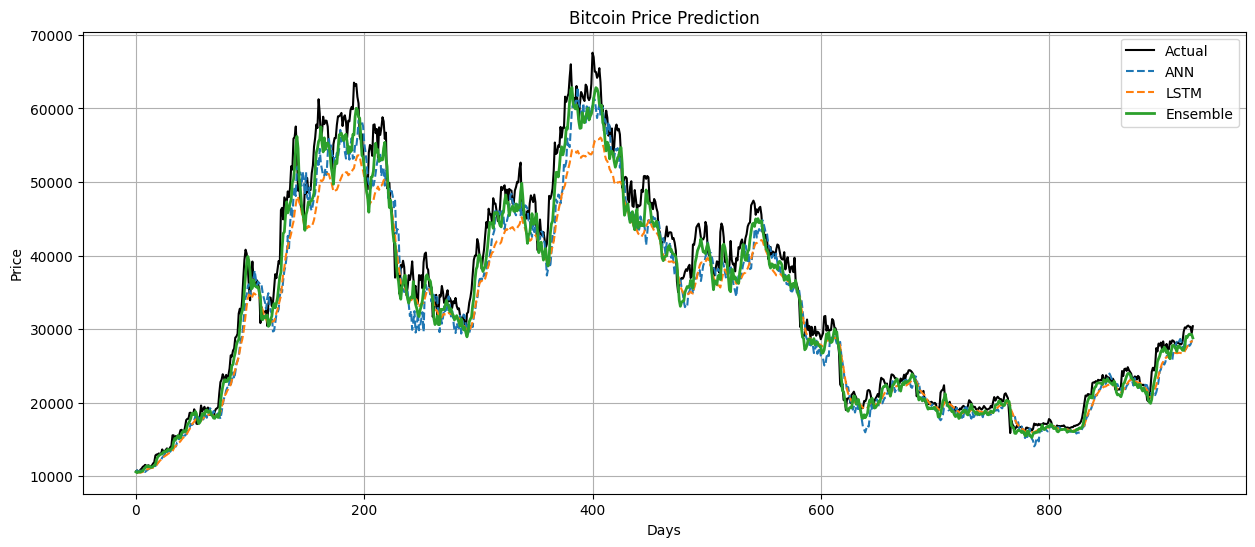

In [36]:
plt.figure(figsize=(15, 6))
plt.plot(y_test_inv, label='Actual', color='black')
plt.plot(ann_pred, label='ANN', linestyle='--')
plt.plot(lstm_pred, label='LSTM', linestyle='--')
plt.plot(ensemble_pred, label='Ensemble', linewidth=2)
plt.title("Bitcoin Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

